In [3]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.utils.convtools import compute_output_shape, conviter
import scipy as sp

In [4]:
def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]


def moving_average(data: np.ndarray, kernel_size: int = 20) -> np.ndarray:
    """
    Compute the moving average of a given data array.

    Parameters
    ----------
    data : np.ndarray
        The data array.
    kernel_size : int
        The size of the kernel.

    Returns
    -------
    np.ndarray
        The moving average of the data array.
    """
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(data, kernel, mode='same')

def interpolate_sequence(original_sequence: np.ndarray, new_length: int) -> np.ndarray:
    """
    Interpolate a sequence of length 'n' into a sequence of length 'm' (m > n)

    Args:
        original_sequence: A numpy array of shape (n, ) representing the original sequence
        new_length: An integer, the desired length of the interpolated sequence

    Returns:
        A numpy array of shape (m, ) representing the interpolated sequence
    """
    x = np.arange(original_sequence.shape[0])
    f = original_sequence
    x_new = np.linspace(0, x.max(), new_length)
    f_new = np.interp(x_new, x, f)
    return f_new

# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [3]:
def generate_event_sequences(n_channels, n_events, n_transitions, group_size):
    all_events = list()

    for _ in range(n_events):
        all_transitions = list()
        for _ in range(n_transitions):
            all_channels = list(range(n_channels))

            new_involved = np.random.choice(all_channels, group_size, replace=False)
            all_transitions.append(new_involved)

        all_events.append(all_transitions)

    return np.array(all_events)


def plv(theta1, theta2):
    complex_phase_diff = np.exp(complex(0, 1)*(theta1 - theta2))
    plv = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return plv

def connectivity(data, measure):
    matrix = list()
    for i_channel, _ in enumerate(data):
        row = list()
        for j_channel, _ in enumerate(data):
            row.append(measure(data[i_channel], data[j_channel]))
        matrix.append(row)
    return np.array(matrix)

In [4]:
transitions = generate_event_sequences(
    n_channels=100,
    n_events=3,
    n_transitions=5,
    group_size=4
)

In [5]:
transitions.shape

(3, 5, 4)

In [6]:
def epoch_from_transitions(transitions, window_size, n_channels, ma1=20, ma2=5):
    n_transitions = len(transitions)
    n_timepoints = (n_transitions + 1)*window_size
    # data = np.array([gaussian_random_walk(n_timepoints) for _ in range(n_channels)])
    # data = 2*np.random.random((n_channels, n_timepoints)) - 1
    data = np.random.normal(0, 1, (n_channels, n_timepoints))
    # data = np.zeros((n_channels, n_timepoints))
    # data = np.array([moving_average(ch, ma1) for ch in data])
    slices = list()

    for n_transition, transition in enumerate(transitions):
        from_ = n_transition*window_size
        to = (n_transition + 1)*window_size
        slices.append(slice(from_, to))
        for ch_ind in transition:
            data[ch_ind, from_:to] = np.random.normal(0, 3, (to-from_,))
            # data[ch_ind, from_:to] = np.ones((to-from_,))
    return data, slices

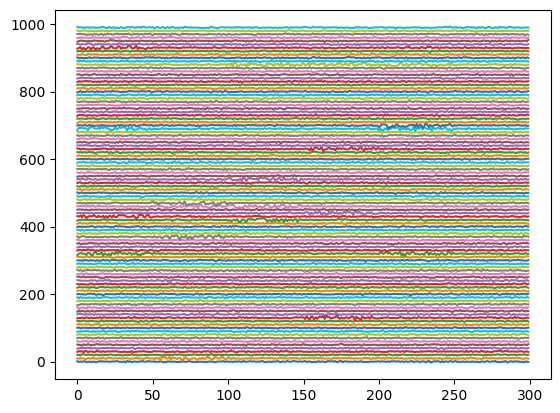

In [7]:
epoch, slices = epoch_from_transitions(transitions[0, :, :], 50, 100)
for i, ch_data in enumerate(epoch):
    plt.plot(ch_data + i*10)

In [ ]:


for slice_ in slices:
    connectome = connectivity(epoch[:, slice_], plv)
    # connectome = connectivity(epoch[:, slice_], lambda x, y: sp.signal.coherence(x, y)[1].mean())
    for i in range(len(connectome)):
        connectome[i, i] = 0
    plt.imshow(connectome)
    plt.show()


In [208]:
a = torch.rand(100, 204, 20)

b = torch.rand(20, 10)

(a@b).shape

torch.Size([100, 204, 10])

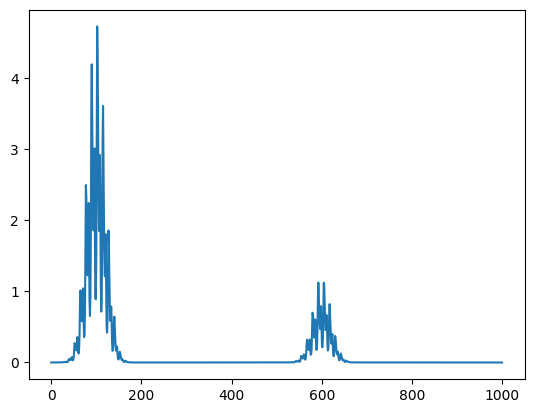

In [3]:
t = np.linspace(0, 1000, 1000)

s = (
        np.exp(
            np.sin(t/2)
        ) + np.exp(
            np.sin(t)
        )
    ) * np.exp(
        -(t - 100)**2 / (2 * 20**2)
    ) + 0.25*(
        np.exp(
            np.sin(t/2)
        ) + np.exp(
            np.sin(t)
        )
    ) * np.exp(
        -(t - 600)**2 / (2 * 20**2)
    )

plt.plot(t, s)

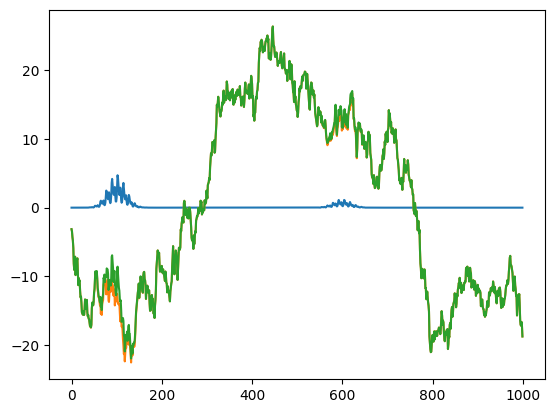

In [4]:
import scipy as sp

original_sig = s#gaussian_random_walk(100)
additional_sig = sp.signal.detrend(gaussian_random_walk(1000))

plt.plot(original_sig)
plt.plot(additional_sig)
plt.plot(original_sig + additional_sig)

In [5]:
n_epochs = 1000
n_channels = 10

poor_data = np.array([ [ sp.signal.detrend(gaussian_random_walk(1000)) for __ in range(n_channels)] for _ in range(n_epochs)])

# distances = np.random.random(n_channels)
distances = np.random.normal(0.5, .2, n_channels)

In [6]:
rich_data = np.array([ [ channel + distance*original_sig for channel, distance in zip(epoch, distances) ] for epoch in poor_data])

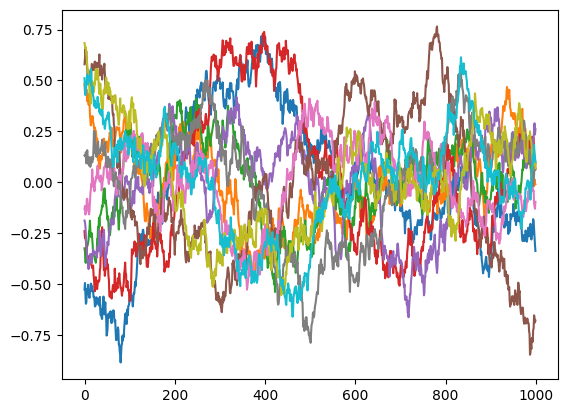

In [7]:
fig = plt.plot(poor_data.mean(0).T)

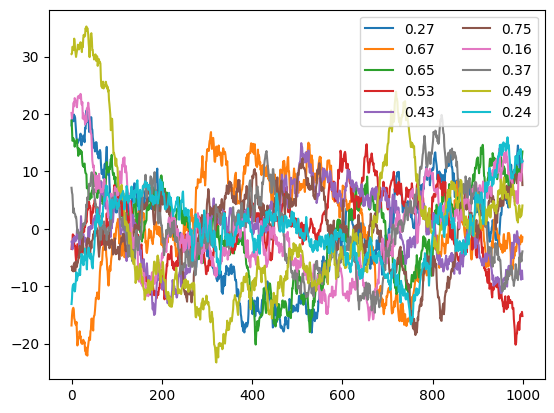

In [8]:
i = int(np.random.randint(len(rich_data)))

fig = plt.plot(rich_data[i].T)
plt.legend(np.round(distances, 2), ncol=2, loc='upper right')

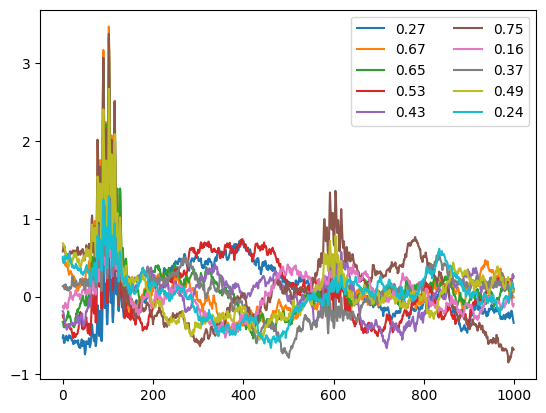

In [9]:
fig = plt.plot(rich_data.mean(0).T)
plt.legend(np.round(distances, 2), ncol=2, loc='upper right')

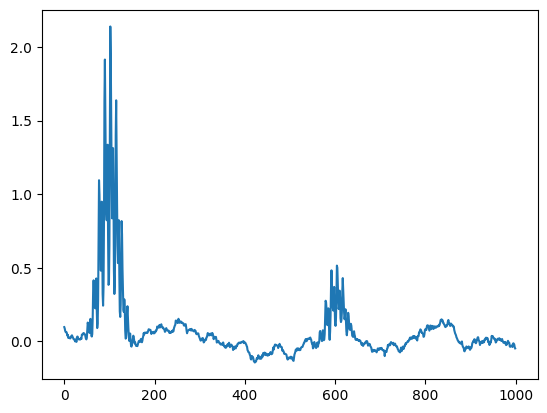

In [10]:
fig = plt.plot(rich_data.mean((0, 1)).T)

In [11]:
data_weighted = np.transpose(np.transpose(rich_data.copy(), (0, 2, 1))@np.expand_dims(distances, 1), (0, 2, 1))

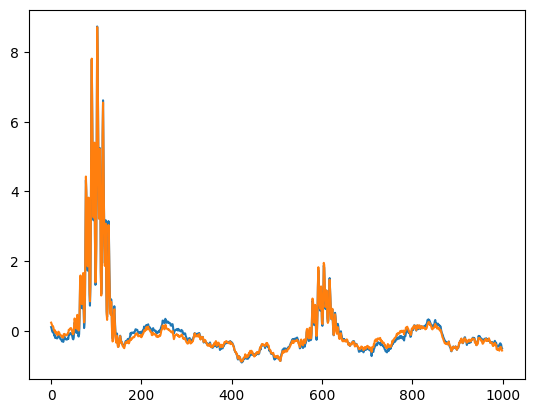

In [12]:
plt.plot(sp.stats.zscore(rich_data.mean((0, 1)).T))
fig = plt.plot(sp.stats.zscore(data_weighted.mean((0, 1)).T))

In [13]:
dist_vec = np.expand_dims(distances, 1)
data_vec = np.transpose(rich_data.copy(), (0, 2, 1))

In [14]:
data_vec[:, 50:150, :] = data_vec[:, 50:150, :]@dist_vec

In [15]:
data_vec[:, 550:650, :] = data_vec[:, 550:650, :]@dist_vec

In [16]:
data_weighted2 = np.transpose(data_vec, (0, 2, 1))

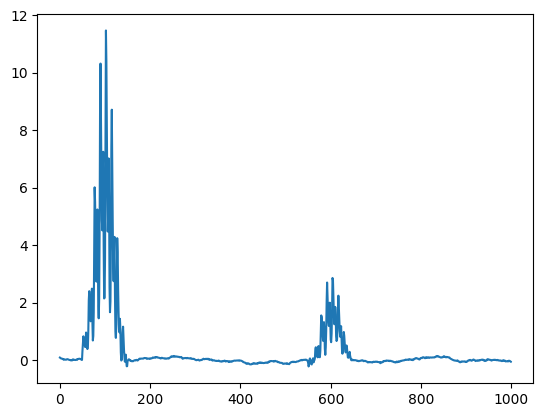

In [17]:
fig = plt.plot(data_weighted2.mean((0, 1)).T)

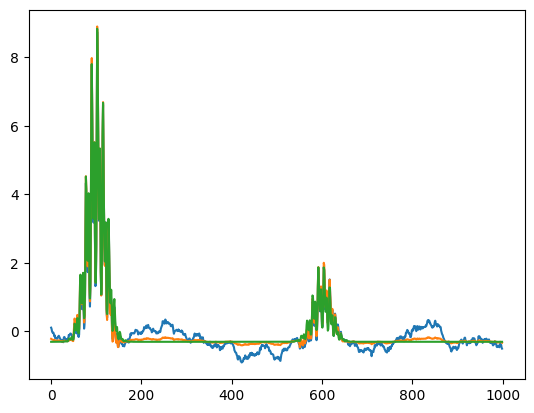

In [18]:
plt.plot(sp.stats.zscore(rich_data.mean((0, 1)).T))
plt.plot(sp.stats.zscore(data_weighted2.mean((0, 1)).T))
plt.plot(sp.stats.zscore(original_sig))
plt.show()

In [19]:
X = rich_data

In [20]:
Y = np.array([original_sig for _ in range(len(X))])

In [21]:
from deepmeg.preprocessing.transforms import zscore

dataset = EpochsDataset((X, Y), transform=zscore, target_transform=zscore, savepath='../datasets/simulated_sources')
dataset.save('../data/simulated_sources.pt')

In [5]:
dataset = EpochsDataset.load('../data/simulated_sources.pt')

In [6]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [180]:
class Unmixer(BaseModel):
    def __init__(self, n_channels, filter_size):
        super().__init__()
        self.temp_conv = nn.Conv1d(n_channels, n_channels, kernel_size=filter_size, bias=True, groups=n_channels, padding='same')
        self.unmixing_layer = nn.Conv1d(n_channels, 1, kernel_size=1, bias=False)
        # self.temp_conv = nn.Conv1d(1, 1, kernel_size=filter_size, bias=True, groups=1, padding='same')

    def forward(self, x):
        x = self.temp_conv(x)
        x = self.unmixing_layer(x)
        # x = self.temp_conv(x)
        return torch.squeeze(x, 1)

In [7]:
X, y = next(iter(DataLoader(train, 10)))

In [25]:

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [139]:
Unmixer(10, 50)(X).shape

torch.Size([10, 1000])

In [181]:
model = Unmixer(
    n_channels=10,
    filter_size=50
)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

# loss = torch.nn.BCEWithLogitsLoss()
loss = torch.nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)

Epoch 0:  loss_train:  0.4837   |    loss_val:  0.4711
Epoch 1:  loss_train:  0.4682   |    loss_val:  0.4610
Epoch 2:  loss_train:  0.4589   |    loss_val:  0.4542
Epoch 3:  loss_train:  0.4525   |    loss_val:  0.4489
Epoch 4:  loss_train:  0.4471   |    loss_val:  0.4442
Epoch 5:  loss_train:  0.4421   |    loss_val:  0.4398
Epoch 6:  loss_train:  0.4372   |    loss_val:  0.4354
Epoch 7:  loss_train:  0.4325   |    loss_val:  0.4309
Epoch 8:  loss_train:  0.4277   |    loss_val:  0.4261
Epoch 9:  loss_train:  0.4230   |    loss_val:  0.4213
Epoch 10: loss_train:  0.4182   |    loss_val:  0.4164
Epoch 11: loss_train:  0.4135   |    loss_val:  0.4117
Epoch 12: loss_train:  0.4089   |    loss_val:  0.4071
Epoch 13: loss_train:  0.4043   |    loss_val:  0.4024
Epoch 14: loss_train:  0.3996   |    loss_val:  0.3975
Epoch 15: loss_train:  0.3948   |    loss_val:  0.3925
Epoch 16: loss_train:  0.3899   |    loss_val:  0.3876
Epoch 17: loss_train:  0.3851   |    loss_val:  0.3828
Epoch 18: 

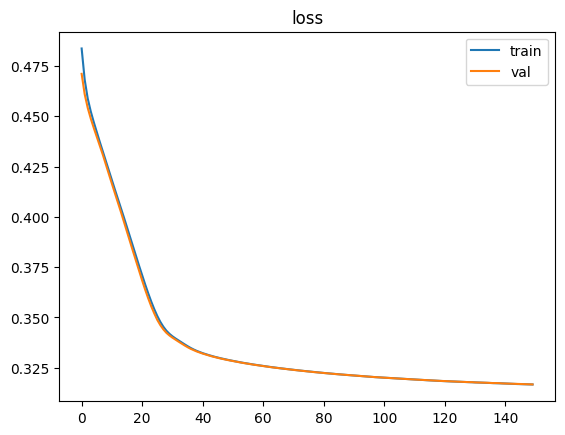

In [182]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [183]:
x_test, y_test = next(iter(DataLoader(test, len(test))))

In [184]:
w = model.unmixing_layer.weight.detach().numpy()

In [185]:
x_test.shape

torch.Size([300, 10, 1000])

In [186]:
np.corrcoef(np.squeeze(np.cov(np.reshape(np.transpose(x_test, (1, 0, -1)), (10, 300000)))@w), distances)[0, 1]

0.20904563765186993

In [187]:
y_pred = model(x_test).detach().numpy()

In [188]:
y_pred.shape

(300, 1000)

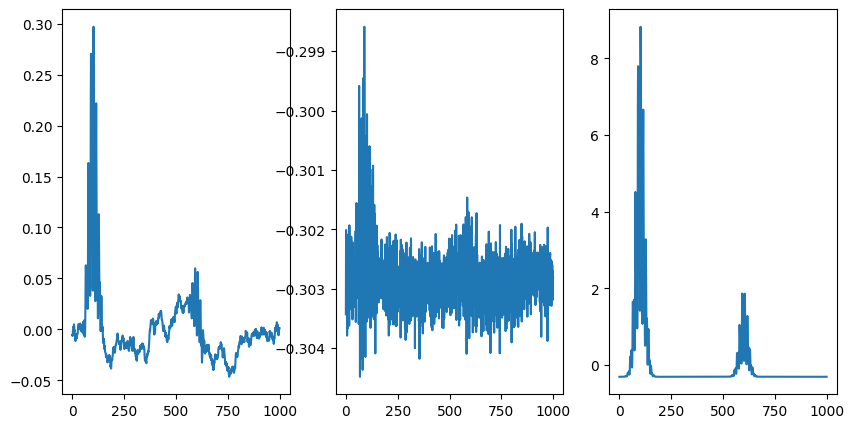

In [189]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

110


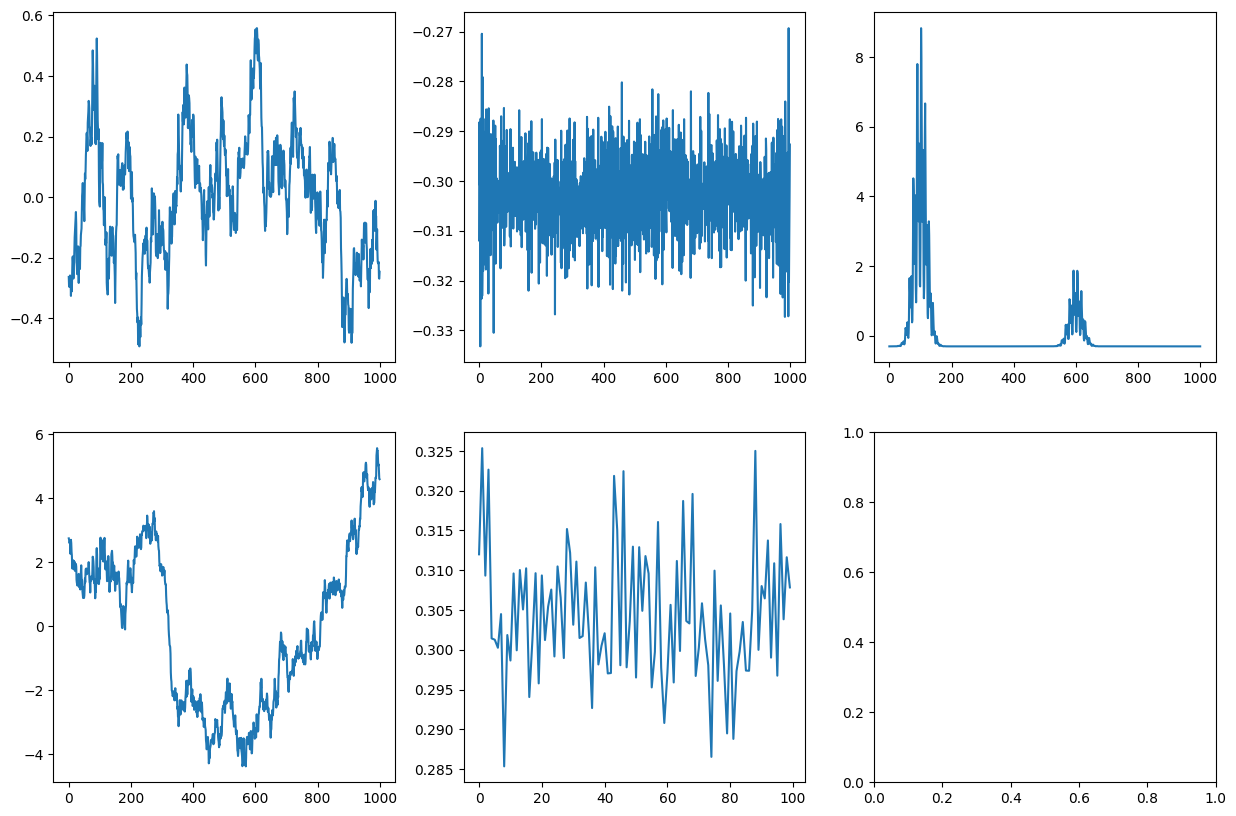

In [203]:
i = int(np.random.randint(len(y_pred)))
print(i)
# data_weighted2
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

x_weighted = (x_test[0].T@distances)

x_weighted2 = x_test[0].T.numpy().copy()
x_weighted2_ = x_weighted2.mean(1)
x_weighted2_[50:150] = x_weighted2[50:150]@distances
x_weighted2_[550:650] = x_weighted2[550:650]@distances

axes[0, 0].plot(x_test[i].mean(0))
axes[0, 1].plot(y_pred[i])
axes[0, 2].plot(y_test[i])
axes[1, 0].plot(x_weighted)
axes[1, 1].plot(np.abs(sp.signal.hilbert(y_pred[i]))[: :10])

In [125]:
x_weighted.shape

torch.Size([])

In [68]:
X.shape

torch.Size([10, 10, 1000])

In [45]:
sys.stdout = sys.stdout.file

In [222]:
print('a')

a


In [59]:
from deepmeg.layers import FourieCov1D

class FourierSPIRIT(BaseModel):
    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        window_size: int,
        latent_dim: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.timesel_list = nn.ModuleList([
            nn.Sequential(
                FourieCov1D(1, window_size, latent_dim, 0, window_size, bias=True),
            )
            for _ in range(n_latent)
        ])
        self.expander = nn.Conv1d(
            in_channels=n_latent,
            out_channels=n_latent,
            kernel_size=(2,),
            padding=1
        )
        self.windows = [win for win, _, _ in conviter((n_times-(window_size),), window_size, 0, window_size)]
        self.windows.append(slice(self.windows[-1].start + window_size, None))
        self.timecomp_list = nn.ModuleList([
            nn.Sequential(
                nn.Linear(
                    n_times,
                    (n_times//pool_factor),
                    bias=False
                ),
                nn.Dropout(.25),
                torch.nn.Sigmoid()
            )
            for i in range(n_latent)
        ])
        final_out_features = (n_times//pool_factor)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x_est = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timesel_list)
            ],
            1
        )

        x_est = torch.squeeze(x_est, -1)
        x_est = self.expander(x_est)

        x_out = list()
        for i, window in enumerate(self.windows):
            x_out.append(
                x[:, :, window]
                *torch.unsqueeze(x_est[:, :, i], -1)
            )

        x = torch.cat(x_out, -1)

        x = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timecomp_list)
            ],
            1
        )
        return torch.squeeze(x, 1)


model = FourierSPIRIT(
    10,
    1,
    1000,
    50,
    20,
    20,
    1,
    1000
)

optimizer = torch.optim.Adam
loss = torch.nn.L1Loss()

model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)


Epoch 0:  loss_train:  0.8687   |    loss_val:  0.8419
Epoch 1:  loss_train:  0.8241   |    loss_val:  0.7821
Epoch 2:  loss_train:  0.7596   |    loss_val:  0.7008
Epoch 3:  loss_train:  0.6827   |    loss_val:  0.6064
Epoch 4:  loss_train:  0.6127   |    loss_val:  0.5213
Epoch 5:  loss_train:  0.5637   |    loss_val:  0.4638
Epoch 6:  loss_train:  0.5392   |    loss_val:  0.4331
Epoch 7:  loss_train:  0.5298   |    loss_val:  0.4185
Epoch 8:  loss_train:  0.5259   |    loss_val:  0.4114
Epoch 9:  loss_train:  0.5246   |    loss_val:  0.4081
Epoch 10: loss_train:  0.5237   |    loss_val:  0.4064
Epoch 11: loss_train:  0.5230   |    loss_val:  0.4053
Epoch 12: loss_train:  0.5224   |    loss_val:  0.4047
Epoch 13: loss_train:  0.5219   |    loss_val:  0.4042
Epoch 14: loss_train:  0.5216   |    loss_val:  0.4038
Epoch 15: loss_train:  0.5209   |    loss_val:  0.4037
Epoch 16: loss_train:  0.5217   |    loss_val:  0.4034
Epoch 17: loss_train:  0.5206   |    loss_val:  0.4033
Epoch 18: 

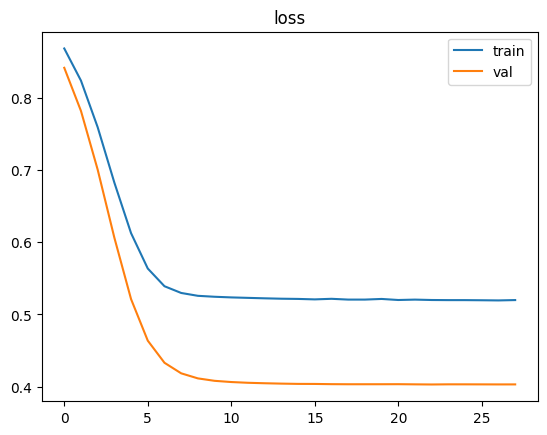

In [60]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [61]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.4029635667800903
loss: 0.4029461443424225


In [62]:
x_test, y_test = next(iter(DataLoader(test, len(test))))
y_pred = model(x_test).detach().numpy()
w = model.unmixing_layer.weight.detach().numpy()
np.corrcoef(np.squeeze(np.cov(np.reshape(np.transpose(x_test, (1, 0, -1)), (10, 300000)))@w), distances)[0, 1]

-0.3743614672082338

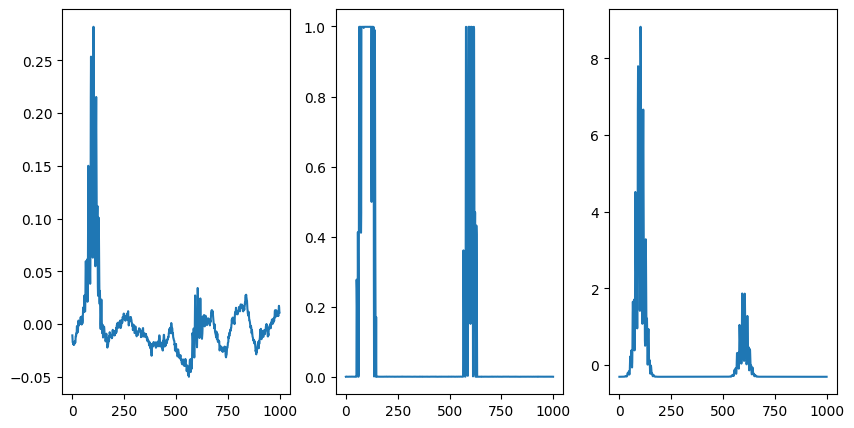

In [63]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

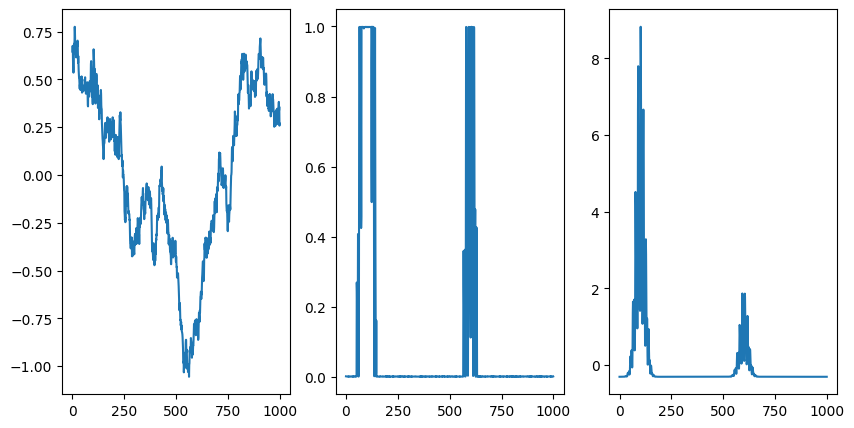

In [67]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test[i].mean((0)))
ax2.plot(y_pred[i])
ax3.plot(y_test[i])

In [46]:

class LFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
    ):
        super().__init__()
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        return torch.squeeze(x, 1)

model = LFCNN(
    10,
    1,
    1000,
    50,
)

optimizer = torch.optim.Adam
loss = torch.nn.L1Loss()

model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)

Epoch 0:  loss_train:  0.6132   |    loss_val:  0.5886
Epoch 1:  loss_train:  0.5781   |    loss_val:  0.5558
Epoch 2:  loss_train:  0.5471   |    loss_val:  0.5284
Epoch 3:  loss_train:  0.5235   |    loss_val:  0.5138
Epoch 4:  loss_train:  0.5143   |    loss_val:  0.5131
Epoch 5:  loss_train:  0.5155   |    loss_val:  0.5144
Epoch 6:  loss_train:  0.5155   |    loss_val:  0.5105
Epoch 7:  loss_train:  0.5103   |    loss_val:  0.5032
Epoch 8:  loss_train:  0.5027   |    loss_val:  0.4964
Epoch 9:  loss_train:  0.4967   |    loss_val:  0.4924
Epoch 10: loss_train:  0.4931   |    loss_val:  0.4900
Epoch 11: loss_train:  0.4905   |    loss_val:  0.4870
Epoch 12: loss_train:  0.4869   |    loss_val:  0.4828
Epoch 13: loss_train:  0.4825   |    loss_val:  0.4784
Epoch 14: loss_train:  0.4784   |    loss_val:  0.4746
Epoch 15: loss_train:  0.4749   |    loss_val:  0.4714
Epoch 16: loss_train:  0.4718   |    loss_val:  0.4681
Epoch 17: loss_train:  0.4684   |    loss_val:  0.4645
Epoch 18: 

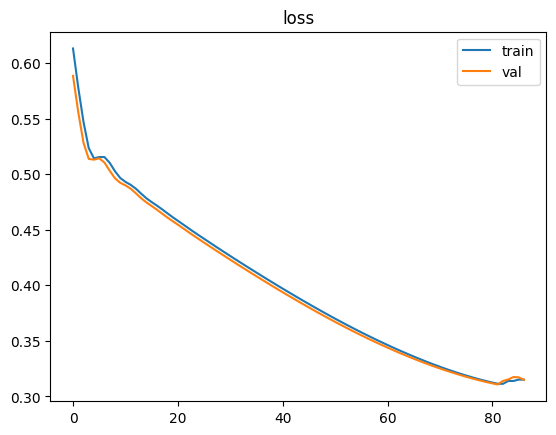

In [47]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [49]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.3107568144798279
loss: 0.3107598602771759


In [51]:
x_test, y_test = next(iter(DataLoader(test, len(test))))
y_pred = model(x_test).detach().numpy()
w = model.unmixing_layer.weight.detach().numpy()
np.corrcoef(np.squeeze(np.cov(np.reshape(np.transpose(x_test, (1, 0, -1)), (10, 300000)))@w), distances)[0, 1]

0.07982320070603602

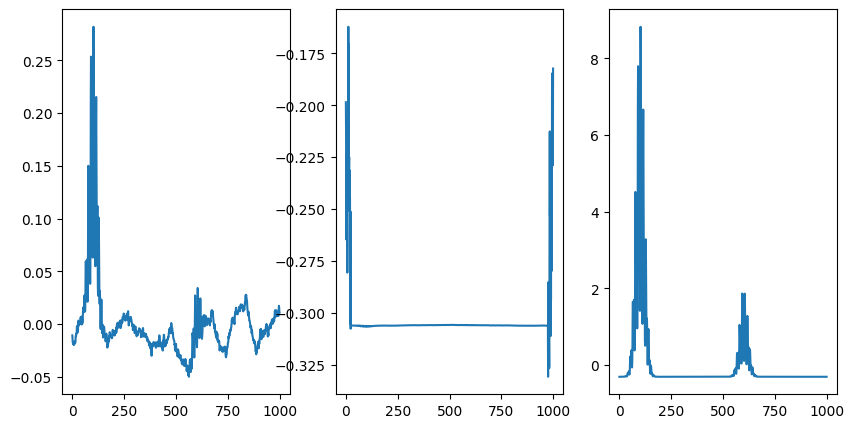

In [52]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

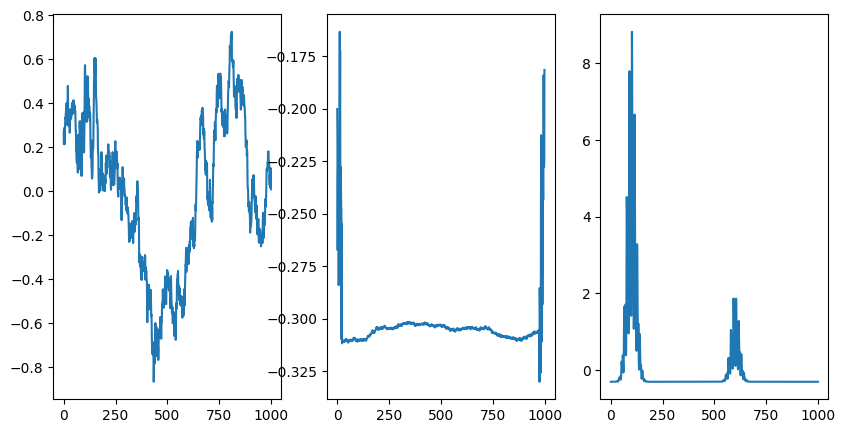

In [58]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test[i].mean((0)))
ax2.plot(y_pred[i])
ax3.plot(y_test[i])

In [56]:
class RUnmixer(BaseModel):
    def __init__(self, n_channels, n_hidden=1):
        super().__init__()
        self.unmixing_layer = nn.LSTM(n_channels, n_hidden, 1, batch_first=True)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        x, _ = self.unmixing_layer(x)
        return torch.squeeze(x, -1)

In [55]:
RUnmixer(10)(X).shape

torch.Size([10, 1000])

In [59]:
sys.stdout = sys.stdout.file

In [60]:
model = RUnmixer(
    n_channels=10,
)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

# loss = torch.nn.BCEWithLogitsLoss()
loss = torch.nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', restore_best_weights=True),
        # L2Reg(
        #     [
        #         'unmixing_layer.weight'
        #     ], lambdas=.01
        # )
    ]
)

Epoch 0:  loss_train:  0.5731   |    loss_val:  0.5741
Epoch 1:  loss_train:  0.5712   |    loss_val:  0.5724
Epoch 2:  loss_train:  0.5694   |    loss_val:  0.5706
Epoch 3:  loss_train:  0.5677   |    loss_val:  0.5689
Epoch 4:  loss_train:  0.5659   |    loss_val:  0.5671
Epoch 5:  loss_train:  0.5642   |    loss_val:  0.5654
Epoch 6:  loss_train:  0.5624   |    loss_val:  0.5637
Epoch 7:  loss_train:  0.5607   |    loss_val:  0.5620
Epoch 8:  loss_train:  0.5590   |    loss_val:  0.5603
Epoch 9:  loss_train:  0.5573   |    loss_val:  0.5587
Epoch 10: loss_train:  0.5557   |    loss_val:  0.5570
Epoch 11: loss_train:  0.5540   |    loss_val:  0.5554
Epoch 12: loss_train:  0.5524   |    loss_val:  0.5538
Epoch 13: loss_train:  0.5508   |    loss_val:  0.5522
Epoch 14: loss_train:  0.5492   |    loss_val:  0.5506
Epoch 15: loss_train:  0.5476   |    loss_val:  0.5491
Epoch 16: loss_train:  0.5460   |    loss_val:  0.5475
Epoch 17: loss_train:  0.5445   |    loss_val:  0.5460
Epoch 18: 

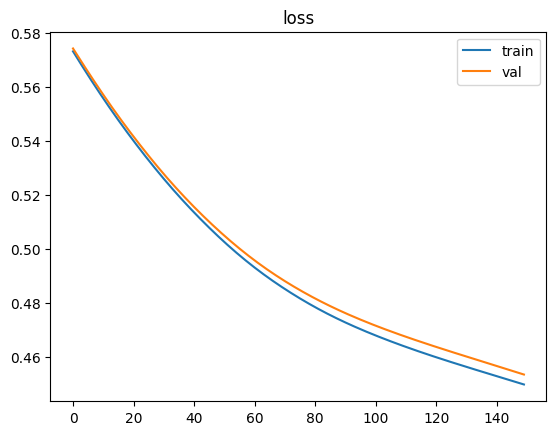

In [61]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [62]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.45061972737312317
loss: 0.4499306738376617


In [64]:
x_test, y_test = next(iter(DataLoader(test, len(test))))
y_pred = model(x_test).detach().numpy()


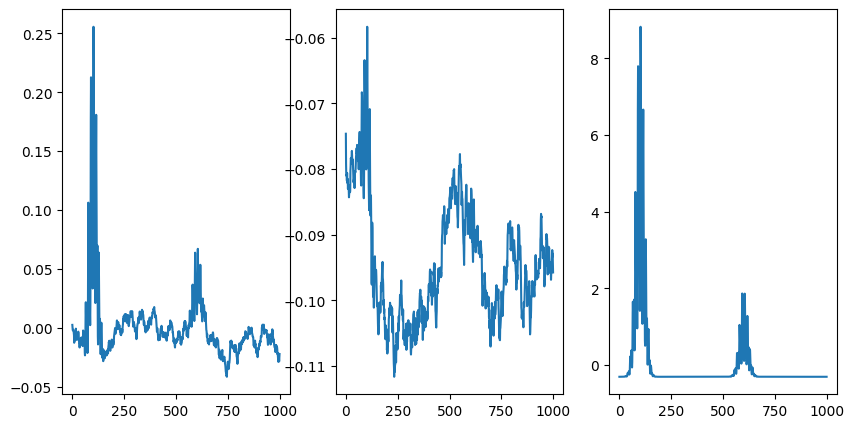

In [74]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

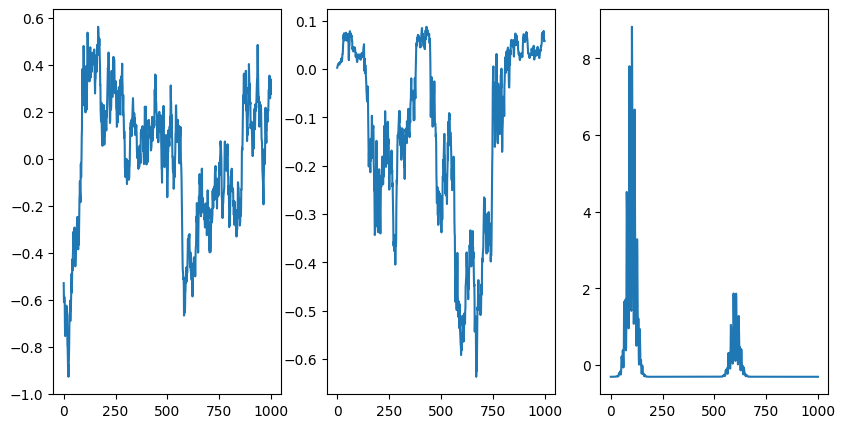

In [73]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test[i].mean((0)))
ax2.plot(y_pred[i])
ax3.plot(y_test[i])